In [7]:
import time
import matplotlib.pyplot as plt
from PIL import Image
from dnn_app_utils_v3 import *
import numpy as np
import matplotlib.pyplot as plt
from testCases import *
from dnn_utils import sigmoid, sigmoid_backward, relu, relu_backward


train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

train_x = train_x_flatten/255
test_x = test_x_flatten/255

import copy
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)


m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]


def initialize_parameters(n_x, n_h, n_y):

    W1 = np.random.randn(n_h,n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))

    parameters = {"W1": W1 , "b1": b1, "W2": W2, "b2": b2}
    
    return parameters  


def initialize_parameters_deep(layer_dims):

    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters


def linear_forward(A, W, b):

    Z = np.dot(W,A) + b
    cache = (A, W, b)
    
    return Z, cache


def linear_activation_forward(A_prev, W, b, activation):

    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    cache = (linear_cache, activation_cache)

    return A, cache


def L_model_forward(X, parameters):

    caches = []
    A = X
    L = len(parameters) // 2  

    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], "relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A,parameters["W" + str(L)],parameters["b" + str(L)],"sigmoid")
    caches.append(cache)

    return AL, caches


def compute_cost(AL, Y):

    m = Y.shape[1]
    cost = (-1/m)*np.sum((np.dot(Y,np.log(AL).T) + np.dot((1-Y),np.log(1-AL).T)),axis = 0, keepdims = True)
    cost = np.squeeze(cost) 

    return cost


def linear_backward(dZ, cache):

    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ, axis = 1 ,keepdims = True)
    dA_prev = np.dot(cache[1].T,dZ)

    return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA,activation_cache )
        dA_prev, dW, db = linear_backward(dZ,linear_cache )
       
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache )
    
    return dA_prev, dW, db


def L_model_backward(AL, Y, caches):

    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) 

    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, "sigmoid")
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] =  dW_temp
    grads["db" + str(L)] = db_temp 

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+1)] =  dW_temp
        grads["db" + str(l+1)] = db_temp
        
    return grads


def update_parameters(params, grads, learning_rate):

    parameters = copy.deepcopy(params)
    L = len(parameters) // 2 

    for l in range(L):
        parameters["W" + str(l+1)] = params["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = params["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]
    
    return parameters


n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.0075


def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
        

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):

    np.random.seed(1)
    costs = []   

    parameters =  initialize_parameters_deep(layers_dims)

    for i in range(0, num_iterations):
        AL , caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs


In [8]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500 , print_cost = True)



Cost after iteration 0: 0.6923799160908503
Cost after iteration 100: 0.6461586699206975
Cost after iteration 200: 0.6317752454522949
Cost after iteration 300: 0.6000906114062464
Cost after iteration 400: 0.5594266141002633
Cost after iteration 500: 0.5129882975097562
Cost after iteration 600: 0.4548146042072384
Cost after iteration 700: 0.39938804920553517
Cost after iteration 800: 0.4205154699577257
Cost after iteration 900: 0.3691844132011299
Cost after iteration 1000: 0.3623927556792381
Cost after iteration 1100: 0.3413659079571165
Cost after iteration 1200: 0.3333440319337271
Cost after iteration 1300: 0.26379708597074125
Cost after iteration 1400: 0.16480532038932788
Cost after iteration 1500: 0.14360822941781876
Cost after iteration 1600: 0.12446701193149183
Cost after iteration 1700: 0.7067523839110107
Cost after iteration 1800: 0.09239377122581145
Cost after iteration 1900: 0.0785723824020304
Cost after iteration 2000: 0.06809230848758144
Cost after iteration 2100: 0.0596490485

Accuracy: 1.0
y = 1.0, your L-layer model predicts a "cat" picture.


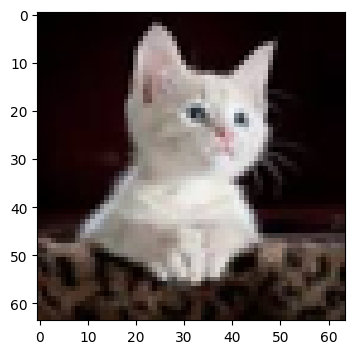

In [9]:
my_image = "my_image.jpeg" # change this to the name of image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)


fname = "images/" + my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T

my_predicted_image = predict(image, my_label_y, parameters)


print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")